In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from enum import Enum
import random
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
MODEL_PATH = 'model.pth'

In [4]:
class Card:
    """
    Game card class
    """
    def __init__(self, rank: int, seed: int):
        self.rank = int(rank)
        self.seed = int(seed)

    def __str__(self):
        return f"{self.get_rank()} of {self.get_seed()}"

    def __hash__(self):
        return self.seed * 10 + self.rank

    def get_value(self) -> int:
        """
        Get the point value of the card based on its rank
        """
        point_values = {
            0: 11,
            1: 0,
            2: 10,
            3: 0,
            4: 0,
            5: 0,
            6: 0,
            7: 2,
            8: 3,
            9: 4,
        }
        return point_values.get(self.rank, 0)

    @staticmethod
    def get_value_from_hash(card_hash: int) -> int:
        """
        Get the point value of the card based on its rank from hash
        """
        point_values = {
            0: 11,
            1: 0,
            2: 10,
            3: 0,
            4: 0,
            5: 0,
            6: 0,
            7: 2,
            8: 3,
            9: 4,
        }
        return point_values[card_hash % 10]

    def get_rank(self) -> str:
        """
        Get the rank of the card as string
        """
        ranks = {
            0: "Ace",
            1: "Two",
            2: "Three",
            3: "Four",
            4: "Five",
            5: "Six",
            6: "Seven",
            7: "Knave",
            8: "Knight",
            9: "King"
        }
        return ranks.get(self.rank, "Unknown")

    def get_seed(self) -> str:
        """
        Get the seed of the card as string
        """
        seeds = {
            0: "Cups",
            1: "Denari",
            2: "Swords",
            3: "Sticks"
        }
        return seeds.get(self.seed, "Unknown")

    def compare_cards(self, other_card: 'Card') -> 'Card':
        """
        Compare two cards to determine the winner ONLY based on their ranks, NOT the seed
        """
        if self.get_value() > other_card.get_value():
            return self
        else:
            return other_card

class CardState(Enum):
    NOT_IN_GAME_YET = 0
    BRISCOLA = 1
    IN_P1_HAND = 2
    IN_P2_HAND = 3
    PLAYED = 4
    PLAYED_IN_PREVIOUS_TURNS = 5

# -----------------------------
# PyTorch Network Definition
# -----------------------------
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        # Input shape is (40,40), flatten to 1600
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(40 * 40, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 32)
        self.fc5 = nn.Linear(32, 3)  # output dimension is 3

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        # For DQN we return raw Q-values (no softmax)
        x = self.fc5(x)
        return x

# -----------------------------
# Agent using DQN with PyTorch
# -----------------------------
class Agent:
    """
    BriscolAI Agent using DQN technique with PyTorch.
    """
    def __init__(self, gamma: float, memory_limit: int = 1000, lr: float = 0.001):
        self.gamma = gamma
        self.memory_limit = memory_limit
        self.memory = []
        self.previous_state = None
        self.state = None

        # Create the action and target networks
        self.action_model = DQN().to(device)
        self.target_model = DQN().to(device)
        # Initialize target model with action model weights
        self.target_model.load_state_dict(self.action_model.state_dict())

        # Define optimizer and loss function (MSE loss)
        self.optimizer = optim.Adam(self.action_model.parameters(), lr=lr)
        self.criterion = nn.MSELoss()

    def set_state(self, state: np.ndarray):
        """
        Set the new state and automatically update the previous state.
        """
        if self.state is None:
            self.previous_state = state
        else:
            self.previous_state = self.state
        self.state = state

    def get_state(self) -> np.ndarray:
        return np.copy(self.state)

    def get_previous_state(self) -> np.ndarray:
        return self.previous_state

    def get_action(self) -> int:
        self.action_model.eval()
        # Convert state to tensor
        state_input = torch.tensor(self.state, dtype=torch.float32, device=device).unsqueeze(0)
        with torch.no_grad():
            q_values = self.action_model(state_input).cpu().numpy()[0]
        return int(np.argmax(q_values))

    def save_in_memory(self, game_id: int, player: int, state: np.ndarray, action: int, reward: int, new_state: np.ndarray, done: bool):
        # If memory exceeds the limit, drop the oldest half
        if len(self.memory) >= self.memory_limit:
            self.memory = self.memory[int(self.memory_limit / 2):]
        experience = {
            "game_id": game_id,
            "player": player,
            "current_state": state,
            "action": action,
            "reward": reward,
            "next_state": new_state,
            "done": done
        }
        self.memory.append(experience)

    def train(self, batch_size: int = 30):
        if len(self.memory) < batch_size:
            return  # not enough samples yet

        # Randomly sample a batch of experiences
        batch_sample = random.sample(self.memory, batch_size)

        # Build training batches and convert to tensors
        states = np.array([exp["current_state"] for exp in batch_sample])
        states_tensor = torch.tensor(states, dtype=torch.float32, device=device).view(batch_size, 40, 40)
        
        # Get current Q-values from action model
        self.action_model.train()
        predictions = self.action_model(states_tensor)
        targets = predictions.clone().detach()

        # Process each sample individually (batch is small)
        for i, exp in enumerate(batch_sample):
            next_state_tensor = torch.tensor(exp["next_state"], dtype=torch.float32, device=device).view(1, 40, 40)
            with torch.no_grad():
                q_target_next = self.target_model(next_state_tensor)
            if not exp["done"]:
                target_value = exp["reward"] + self.gamma * torch.max(q_target_next)
            else:
                target_value = exp["reward"]
            targets[i, exp["action"]] = target_value

        # Compute loss and perform a training step
        loss = self.criterion(predictions, targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

# -----------------------------
# Game Environment: Briscola
# -----------------------------
class Briscola:
    def __init__(self):
        self.reset()

    def __str__(self):
        out = f'''Cards in the deck: {len(self.deck) + 1} 
Briscola: {self.briscola_card} 
Played Card: {self.played_card}\n\n'''
        out += 'Your hand:\n'
        for idx, card in enumerate(self.p2_hand):
            out += f'{idx}) {card}\n'
        return out

    def get_P1_state(self) -> np.ndarray:
        p1_state = np.copy(self.state)
        p1_state[p1_state == CardState.IN_P2_HAND.value] = CardState.NOT_IN_GAME_YET.value
        return p1_state

    def get_P2_state(self) -> np.ndarray:
        p2_state = np.copy(self.state)
        p2_state[p2_state == CardState.IN_P1_HAND.value] = CardState.NOT_IN_GAME_YET.value
        return p2_state

    @staticmethod
    def print_state(state):
        # Utility function to save a state as csv
        df = pd.DataFrame(state)
        df.to_csv('data.csv', index=False)

    def draw_card(self) -> Card:
        """
        Each player draws from the deck, removing cards from the deck list.
        """
        if len(self.deck) == 0:
            self.briscola_drawn = True
            return self.briscola_card
        return self.deck.pop(0)

    def create_deck(self) -> list:
        """
        Create a new deck with cards in random order.
        """
        deck = [Card(rank, seed) for rank in range(10) for seed in range(4)]
        np.random.shuffle(deck)
        return deck

    def fight(self, first_card: Card, second_card: Card):
        """
        Tells who wins between the two cards.
        """
        if first_card.seed == second_card.seed:
            return first_card.compare_cards(second_card)
        if first_card.seed == self.briscola_card.seed:
            return first_card
        if second_card.seed == self.briscola_card.seed:
            return second_card
        return first_card

    def fight_hash(self, first_card_hash: int, second_card_hash: int):
        """
        Determines the winning card based on their hash.
        Returns the hash of the winning card.
        """
        if first_card_hash // 10 == second_card_hash // 10:
            power = {
                0: 9,  # Ace
                1: 0,  # Two
                2: 8,  # Three
                3: 1,  # Four
                4: 2,  # Five
                5: 3,  # Six
                6: 4,  # Seven
                7: 5,  # Knave
                8: 6,  # Knight
                9: 7   # King
            }
            if power[first_card_hash % 10] > power[second_card_hash % 10]:
                return first_card_hash
            else:
                return second_card_hash

        if first_card_hash // 10 == self.briscola_card.seed:
            return first_card_hash
        if second_card_hash // 10 == self.briscola_card.seed:
            return second_card_hash
        return first_card_hash

    def reset(self, ai_turn: bool = None):
        """Reset the current environment."""
        self.deck = self.create_deck()
        self.p1_hand = []
        self.p2_hand = []
        self.p1_hand.append(self.draw_card())
        self.p1_hand.append(self.draw_card())
        self.p1_hand.append(self.draw_card())
        self.p2_hand.append(self.draw_card())
        self.p2_hand.append(self.draw_card())
        self.p2_hand.append(self.draw_card())
        self.briscola_card = self.draw_card()
        self.briscola_drawn = False

        self.p1_score, self.p2_score = 0, 0
        self.turn = 0 if ai_turn is None else int(ai_turn)
        self.turn_number = 0

        self.state = np.full((40, 40), CardState.NOT_IN_GAME_YET.value)
        self.state[hash(self.briscola_card), :] = CardState.BRISCOLA.value

        for card in self.p1_hand:
            self.state[hash(card), 0] = CardState.IN_P1_HAND.value
        for card in self.p2_hand:
            self.state[hash(card), 0] = CardState.IN_P2_HAND.value

        self.played_card = None
        self.episode_ended = False

    def step(self, action: int):
        """Apply action and return new state, reward, and done flag."""
        current_hand = self.p1_hand if self.turn == 0 else self.p2_hand
        if action < 0 or action >= len(current_hand):
            return self.state, -10000, False

        if self.turn_number > 0:
            self.state[:, self.turn_number] = self.state[:, self.turn_number - 1]

        chosen_card = current_hand[action]
        reward = 0
        winner = (self.turn + 1) % 2

        if self.turn_number % 2 == 0:
            self.state[self.state[:, self.turn_number] == CardState.PLAYED.value, self.turn_number] = CardState.PLAYED_IN_PREVIOUS_TURNS.value
            self.played_card = chosen_card
        else:
            winning_hash = self.fight_hash(hash(self.played_card), hash(chosen_card))
            winner = self.turn if winning_hash == hash(chosen_card) else (self.turn + 1) % 2
            reward = Card.get_value_from_hash(hash(chosen_card)) + Card.get_value_from_hash(hash(self.played_card))

        self.state[hash(chosen_card), self.turn_number] = CardState.PLAYED.value

        if self.turn_number % 2 != 0:
            if winner == 0:
                self.p1_score += reward
                if not self.briscola_drawn:
                    self.p1_hand.append(self.draw_card())
                    self.p2_hand.append(self.draw_card())
            else:
                self.p2_score += reward
                if not self.briscola_drawn:
                    self.p2_hand.append(self.draw_card())
                    self.p1_hand.append(self.draw_card())
            if not self.briscola_drawn:
                self.state[hash(self.p1_hand[-1]), self.turn_number] = CardState.IN_P1_HAND.value
                self.state[hash(self.p2_hand[-1]), self.turn_number] = CardState.IN_P2_HAND.value
            self.played_card = None

        if self.turn == 0:
            self.p1_hand.pop(action)
        else:
            self.p2_hand.pop(action)

        self.turn_number += 1
        if winner != self.turn:
            self.turn = (self.turn + 1) % 2

        self.episode_ended = (len(self.p1_hand) == 0 and len(self.p2_hand) == 0)
        return self.state, reward, self.episode_ended

    def is_playing(self):
        return not self.episode_ended

    def get_winner(self):
        if self.p1_score > self.p2_score:
            return 0
        elif self.p2_score > self.p1_score:
            return 1
        return 2

Training phase started...
Episode: 1/5000 | Epsilon: 1.0000
Winner: 1, Score p1: 57, Score p2: 63
Episode: 2/5000 | Epsilon: 0.9990
Winner: 0, Score p1: 69, Score p2: 51
Episode: 3/5000 | Epsilon: 0.9980
Winner: 1, Score p1: 57, Score p2: 63
Episode: 4/5000 | Epsilon: 0.9970
Winner: 1, Score p1: 43, Score p2: 77
Episode: 5/5000 | Epsilon: 0.9960
Winner: 1, Score p1: 36, Score p2: 84
Episode: 6/5000 | Epsilon: 0.9950
Winner: 1, Score p1: 35, Score p2: 85
Episode: 7/5000 | Epsilon: 0.9940
Winner: 1, Score p1: 46, Score p2: 74
Episode: 8/5000 | Epsilon: 0.9930
Winner: 1, Score p1: 47, Score p2: 73
Episode: 9/5000 | Epsilon: 0.9920
Winner: 1, Score p1: 28, Score p2: 92
Episode: 10/5000 | Epsilon: 0.9910
Winner: 0, Score p1: 82, Score p2: 38
Episode: 11/5000 | Epsilon: 0.9900
Winner: 1, Score p1: 59, Score p2: 61
Episode: 12/5000 | Epsilon: 0.9891
Winner: 1, Score p1: 59, Score p2: 61
Episode: 13/5000 | Epsilon: 0.9881
Winner: 1, Score p1: 46, Score p2: 74
Episode: 14/5000 | Epsilon: 0.9871

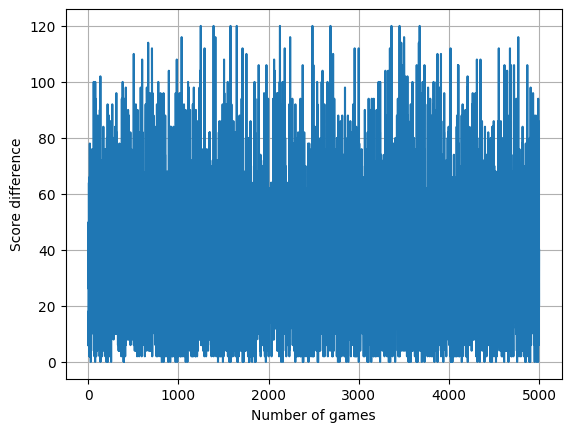

In [5]:
if not os.path.exists(MODEL_PATH):
    print("Training phase started...")
    total_episodes = 5000        # Total episodes
    gamma = 0.99                 # Discount factor

    # Exploration parameters
    epsilon = 1.0                # Exploration rate
    epsilon_min = 0.01           # Minimum exploration probability
    epsilon_decay = 0.001        # Exponential decay rate for exploration prob
    precalc_epsilon_decay = np.exp(-epsilon_decay)

    memory_limit = 500           # Memory limit for the agent
    saving_rate = 100            # Saving frequency (in episodes)
    rewards = []

    briscolAI = Agent(gamma, memory_limit)

    for episode in range(1, total_episodes+1):
        print(f"Episode: {episode}/{total_episodes} | Epsilon: {epsilon:.4f}")
        game = Briscola()

        while game.is_playing():
            current_state = game.get_P1_state() if game.turn == 0 else game.get_P2_state()
            briscolAI.set_state(current_state)
            current_hand = game.p1_hand if game.turn == 0 else game.p2_hand
            if np.random.uniform(0, 1) < epsilon:
                action = np.random.randint(0, len(current_hand))
            else:
                action = briscolAI.get_action()
            new_state, reward, episode_ended = game.step(action)
            next_state = game.get_P1_state() if game.turn == 1 else game.get_P2_state()
            briscolAI.save_in_memory(episode, game.turn, briscolAI.get_previous_state(), action, reward, next_state, not game.is_playing())

        last_session_id = episode
        winning_player = game.get_winner()
        score_difference = abs(game.p1_score - game.p2_score)
        for exp in reversed(briscolAI.memory):
            if exp["game_id"] != last_session_id:
                break
            if winning_player != 2:
                if exp["player"] == winning_player:
                    exp["reward"] += score_difference
                else:
                    exp["reward"] -= score_difference

        print(f"Winner: {winning_player}, Score p1: {game.p1_score}, Score p2: {game.p2_score}")
        briscolAI.train()

        if episode % saving_rate == 0:
            torch.save(briscolAI.action_model.state_dict(), MODEL_PATH)
            print(f"Model saved at episode {episode}")

        epsilon *= precalc_epsilon_decay
        if epsilon < epsilon_min:
            epsilon = epsilon_min

        rewards.append(score_difference)

    print("Training completed!")
    print("Average score difference over time: " + str(sum(rewards)/len(rewards)))
    plt.plot(rewards)
    plt.xlabel('Number of games')
    plt.ylabel('Score difference')
    plt.grid(True)
    plt.show()
else:
    print("Saved model found. Loading the model for interactive play...")
    gamma = 0.99  # ensure gamma is the same as during training
    briscolAI = Agent(gamma)
    briscolAI.action_model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    briscolAI.target_model.load_state_dict(torch.load(MODEL_PATH, map_location=device))

In [ ]:

print("\nInteractive play begins!")
game = Briscola()
ai_turn = np.random.uniform(0, 1) < 0.5
game.reset(ai_turn)

while game.is_playing():
    print("---------------------------------------------")
    print(game)
    previous_played_card = game.played_card

    if ai_turn:
        print("Player turn:")
        print(f"Select the card index (e.g., 0 to select {game.p2_hand[0]}):")
        try:
            action = int(input())
        except ValueError:
            print("Invalid input, try again.")
            continue
        if action < 0 or action >= len(game.p2_hand):
            print("Invalid action index, try again.")
            continue
        current_played_card = game.p2_hand[action]
        print(f"Player played {current_played_card}\n")
        new_state, reward, episode_ended = game.step(action)
    else:
        print("BriscolAI turn:")
        action = np.random.randint(0, len(game.p1_hand))
        current_played_card = game.p1_hand[action]
        print(f"BriscolAI played {current_played_card}\n")
        new_state, reward, episode_ended = game.step(action)
    print(f"Game turn: {game.turn_number}")
    if game.turn_number % 2 == 0 and previous_played_card is not None:
        if game.turn == 0:
            print(f"BriscolAI took {previous_played_card} with {current_played_card}")
        else:
            print(f"Human took {previous_played_card} with {current_played_card}")
    ai_turn = not ai_turn

print(game)
winner = game.get_winner()
if winner == 2:
    print("It's a draw!")
elif winner == 0:
    print("BriscolAI wins!")
else:
    print("You win!")



Interactive play begins!
---------------------------------------------
Cards in the deck: 34 
Briscola: King of Sticks 
Played Card: None

Your hand:
0) Knave of Swords
1) Six of Swords
2) Two of Swords

BriscolAI turn:
BriscolAI played Four of Cups

Game turn: 1
---------------------------------------------
Cards in the deck: 34 
Briscola: King of Sticks 
Played Card: Four of Cups

Your hand:
0) Knave of Swords
1) Six of Swords
2) Two of Swords

Player turn:
Select the card index (e.g., 0 to select Knave of Swords):
Invalid input, try again.
---------------------------------------------
Cards in the deck: 34 
Briscola: King of Sticks 
Played Card: Four of Cups

Your hand:
0) Knave of Swords
1) Six of Swords
2) Two of Swords

Player turn:
Select the card index (e.g., 0 to select Knave of Swords):
Invalid input, try again.
---------------------------------------------
Cards in the deck: 34 
Briscola: King of Sticks 
Played Card: Four of Cups

Your hand:
0) Knave of Swords
1) Six of Swo

# ---

Training phase started...
Episode: 1/50000 | Epsilon: 1.0000
Winner: 1, Score p1: 28, Score p2: 92
Episode: 2/50000 | Epsilon: 0.9999
Winner: 1, Score p1: 33, Score p2: 87
Episode: 3/50000 | Epsilon: 0.9998
Winner: 0, Score p1: 81, Score p2: 39
Episode: 4/50000 | Epsilon: 0.9997
Winner: 1, Score p1: 27, Score p2: 93
Episode: 5/50000 | Epsilon: 0.9996
Winner: 0, Score p1: 68, Score p2: 52
Episode: 6/50000 | Epsilon: 0.9995
Winner: 0, Score p1: 87, Score p2: 33
Episode: 7/50000 | Epsilon: 0.9994
Winner: 1, Score p1: 38, Score p2: 82
Episode: 8/50000 | Epsilon: 0.9993
Winner: 0, Score p1: 66, Score p2: 54
Episode: 9/50000 | Epsilon: 0.9992
Winner: 0, Score p1: 72, Score p2: 48
Episode: 10/50000 | Epsilon: 0.9991
Winner: 1, Score p1: 49, Score p2: 71
Episode: 11/50000 | Epsilon: 0.9990
Winner: 1, Score p1: 46, Score p2: 74
Episode: 12/50000 | Epsilon: 0.9989
Winner: 1, Score p1: 53, Score p2: 67
Episode: 13/50000 | Epsilon: 0.9988
Winner: 1, Score p1: 23, Score p2: 97
Episode: 14/50000 | E

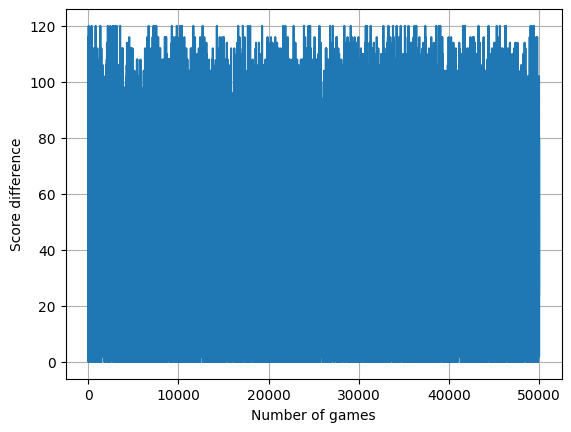


Interactive play begins!
---------------------------------------------
Cards in the deck: 34 
Briscola: Knave of Sticks 
Played Card: None

Your hand:
0) Two of Cups
1) Knight of Swords
2) Seven of Sticks

Player turn:
Select the card index (e.g., 0 to select Two of Cups):
Player played Two of Cups

Game turn: 1
---------------------------------------------
Cards in the deck: 34 
Briscola: Knave of Sticks 
Played Card: Two of Cups

Your hand:
0) Knight of Swords
1) Seven of Sticks

BriscolAI turn:
BriscolAI played Ace of Cups

Game turn: 2
BriscolAI took Two of Cups with Ace of Cups
---------------------------------------------
Cards in the deck: 32 
Briscola: Knave of Sticks 
Played Card: None

Your hand:
0) Knight of Swords
1) Seven of Sticks
2) Five of Cups

Player turn:
Select the card index (e.g., 0 to select Knight of Swords):
Invalid input, try again.
---------------------------------------------
Cards in the deck: 32 
Briscola: Knave of Sticks 
Played Card: None

Your hand:
0)

KeyboardInterrupt: Interrupted by user

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from enum import Enum
import random
import torch
import torch.nn as nn
import torch.optim as optim

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# -----------------------------
# Game Classes (unchanged)
# -----------------------------
class Card:
    """
    Game card class
    """
    def __init__(self, rank: int, seed: int):
        self.rank = int(rank)
        self.seed = int(seed)

    def __str__(self):
        return f"{self.get_rank()} of {self.get_seed()}"

    def __hash__(self):
        return self.seed * 10 + self.rank

    def get_value(self) -> int:
        """
        Get the point value of the card based on its rank
        """
        point_values = {
            0: 11,
            1: 0,
            2: 10,
            3: 0,
            4: 0,
            5: 0,
            6: 0,
            7: 2,
            8: 3,
            9: 4,
        }
        return point_values.get(self.rank, 0)

    @staticmethod
    def get_value_from_hash(card_hash: int) -> int:
        """
        Get the point value of the card based on its rank from hash
        """
        point_values = {
            0: 11,
            1: 0,
            2: 10,
            3: 0,
            4: 0,
            5: 0,
            6: 0,
            7: 2,
            8: 3,
            9: 4,
        }
        return point_values[card_hash % 10]

    def get_rank(self) -> str:
        """
        Get the rank of the card as string
        """
        ranks = {
            0: "Ace",
            1: "Two",
            2: "Three",
            3: "Four",
            4: "Five",
            5: "Six",
            6: "Seven",
            7: "Knave",
            8: "Knight",
            9: "King"
        }
        return ranks.get(self.rank, "Unknown")

    def get_seed(self) -> str:
        """
        Get the seed of the card as string
        """
        seeds = {
            0: "Cups",
            1: "Denari",
            2: "Swords",
            3: "Sticks"
        }
        return seeds.get(self.seed, "Unknown")

    def compare_cards(self, other_card: 'Card') -> 'Card':
        """
        Compare two cards to determine the winner ONLY based on their ranks, NOT the seed
        """
        if self.get_value() > other_card.get_value():
            return self
        else:
            return other_card

class CardState(Enum):
    NOT_IN_GAME_YET = 0
    BRISCOLA = 1
    IN_P1_HAND = 2
    IN_P2_HAND = 3
    PLAYED = 4
    PLAYED_IN_PREVIOUS_TURNS = 5

# -----------------------------
# PyTorch Network Definition
# -----------------------------
class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        # Input shape is (40,40) flattened to 1600 features
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(40 * 40, 32)
        self.fc2 = nn.Linear(32, 32)
        self.fc3 = nn.Linear(32, 32)
        self.fc4 = nn.Linear(32, 32)
        self.fc5 = nn.Linear(32, 3)  # output dimension is 3

    def forward(self, x):
        x = self.flatten(x)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        # For DQN we return raw Q-values (no softmax)
        x = self.fc5(x)
        return x

# -----------------------------
# Agent using DQN with PyTorch
# -----------------------------
class Agent:
    """
    BriscolAI Agent using DQN technique with PyTorch.
    """
    def __init__(self, gamma: float, memory_limit: int = 1000, lr: float = 0.001):
        self.gamma = gamma
        self.memory_limit = memory_limit
        self.memory = []
        self.previous_state = None
        self.state = None

        # Create the action and target networks
        self.action_model = DQN().to(device)
        self.target_model = DQN().to(device)
        self.target_model.load_state_dict(self.action_model.state_dict())

        # Define optimizer and use Huber loss which is often used for DQN
        self.optimizer = optim.Adam(self.action_model.parameters(), lr=lr)
        self.criterion = nn.SmoothL1Loss()

        # For periodic target network update
        self.training_steps = 0
        self.update_target_frequency = 50  # update target network every 50 training steps

    def set_state(self, state: np.ndarray):
        """
        Set the new state and automatically update the previous state.
        """
        if self.state is None:
            self.previous_state = state
        else:
            self.previous_state = self.state
        self.state = state

    def get_state(self) -> np.ndarray:
        return np.copy(self.state)

    def get_previous_state(self) -> np.ndarray:
        return self.previous_state

    def get_action(self) -> int:
        self.action_model.eval()
        state_input = torch.tensor(self.state, dtype=torch.float32, device=device).unsqueeze(0)
        with torch.no_grad():
            q_values = self.action_model(state_input).cpu().numpy()[0]
        return int(np.argmax(q_values))

    def save_in_memory(self, game_id: int, player: int, state: np.ndarray, action: int, reward: int, new_state: np.ndarray, done: bool):
        # If memory exceeds the limit, drop the oldest half
        if len(self.memory) >= self.memory_limit:
            self.memory = self.memory[int(self.memory_limit / 2):]
        experience = {
            "game_id": game_id,
            "player": player,
            "current_state": state,
            "action": action,
            "reward": reward,
            "next_state": new_state,
            "done": done
        }
        self.memory.append(experience)

    def train(self, batch_size: int = 30):
        if len(self.memory) < batch_size:
            return  # not enough samples yet

        batch_sample = random.sample(self.memory, batch_size)
        states = np.array([exp["current_state"] for exp in batch_sample])
        states_tensor = torch.tensor(states, dtype=torch.float32, device=device).view(batch_size, 40, 40)
        
        self.action_model.train()
        predictions = self.action_model(states_tensor)
        targets = predictions.clone().detach()

        # Process each sample
        for i, exp in enumerate(batch_sample):
            # Clip reward to avoid instability from extreme values
            reward = np.clip(exp["reward"], -10, 10)
            next_state_tensor = torch.tensor(exp["next_state"], dtype=torch.float32, device=device).view(1, 40, 40)
            with torch.no_grad():
                q_target_next = self.target_model(next_state_tensor)
            if not exp["done"]:
                target_value = reward + self.gamma * torch.max(q_target_next)
            else:
                target_value = reward
            targets[i, exp["action"]] = target_value

        loss = self.criterion(predictions, targets)
        self.optimizer.zero_grad()
        loss.backward()
        # Clip gradients to prevent explosion
        torch.nn.utils.clip_grad_norm_(self.action_model.parameters(), 1.0)
        self.optimizer.step()

        # Periodically update the target network
        self.training_steps += 1
        if self.training_steps % self.update_target_frequency == 0:
            self.target_model.load_state_dict(self.action_model.state_dict())

# -----------------------------
# Game Environment: Briscola
# -----------------------------
class Briscola:
    def __init__(self):
        self.reset()

    def __str__(self):
        out = f'''Cards in the deck: {len(self.deck) + 1} 
Briscola: {self.briscola_card} 
Played Card: {self.played_card}\n\n'''
        out += 'Your hand:\n'
        for idx, card in enumerate(self.p2_hand):
            out += f'{idx}) {card}\n'
        return out

    def get_P1_state(self) -> np.ndarray:
        p1_state = np.copy(self.state)
        p1_state[p1_state == CardState.IN_P2_HAND.value] = CardState.NOT_IN_GAME_YET.value
        return p1_state

    def get_P2_state(self) -> np.ndarray:
        p2_state = np.copy(self.state)
        p2_state[p2_state == CardState.IN_P1_HAND.value] = CardState.NOT_IN_GAME_YET.value
        return p2_state

    @staticmethod
    def print_state(state):
        df = pd.DataFrame(state)
        df.to_csv('data.csv', index=False)

    def draw_card(self) -> Card:
        if len(self.deck) == 0:
            self.briscola_drawn = True
            return self.briscola_card
        return self.deck.pop(0)

    def create_deck(self) -> list:
        deck = [Card(rank, seed) for rank in range(10) for seed in range(4)]
        np.random.shuffle(deck)
        return deck

    def fight(self, first_card: Card, second_card: Card):
        if first_card.seed == second_card.seed:
            return first_card.compare_cards(second_card)
        if first_card.seed == self.briscola_card.seed:
            return first_card
        if second_card.seed == self.briscola_card.seed:
            return second_card
        return first_card

    def fight_hash(self, first_card_hash: int, second_card_hash: int):
        if first_card_hash // 10 == second_card_hash // 10:
            power = {
                0: 9,
                1: 0,
                2: 8,
                3: 1,
                4: 2,
                5: 3,
                6: 4,
                7: 5,
                8: 6,
                9: 7
            }
            if power[first_card_hash % 10] > power[second_card_hash % 10]:
                return first_card_hash
            else:
                return second_card_hash

        if first_card_hash // 10 == self.briscola_card.seed:
            return first_card_hash
        if second_card_hash // 10 == self.briscola_card.seed:
            return second_card_hash
        return first_card_hash

    def reset(self, ai_turn: bool = None):
        self.deck = self.create_deck()
        self.p1_hand = []
        self.p2_hand = []
        self.p1_hand.append(self.draw_card())
        self.p1_hand.append(self.draw_card())
        self.p1_hand.append(self.draw_card())
        self.p2_hand.append(self.draw_card())
        self.p2_hand.append(self.draw_card())
        self.p2_hand.append(self.draw_card())
        self.briscola_card = self.draw_card()
        self.briscola_drawn = False

        self.p1_score, self.p2_score = 0, 0
        self.turn = 0 if ai_turn is None else int(ai_turn)
        self.turn_number = 0

        self.state = np.full((40, 40), CardState.NOT_IN_GAME_YET.value)
        self.state[hash(self.briscola_card), :] = CardState.BRISCOLA.value

        for card in self.p1_hand:
            self.state[hash(card), 0] = CardState.IN_P1_HAND.value
        for card in self.p2_hand:
            self.state[hash(card), 0] = CardState.IN_P2_HAND.value

        self.played_card = None
        self.episode_ended = False

    def step(self, action: int):
        current_hand = self.p1_hand if self.turn == 0 else self.p2_hand
        if action < 0 or action >= len(current_hand):
            # Return clipped penalty reward for invalid action
            return self.state, -10000, False

        if self.turn_number > 0:
            self.state[:, self.turn_number] = self.state[:, self.turn_number - 1]

        chosen_card = current_hand[action]
        reward = 0
        winner = (self.turn + 1) % 2

        if self.turn_number % 2 == 0:
            self.state[self.state[:, self.turn_number] == CardState.PLAYED.value, self.turn_number] = CardState.PLAYED_IN_PREVIOUS_TURNS.value
            self.played_card = chosen_card
        else:
            winning_hash = self.fight_hash(hash(self.played_card), hash(chosen_card))
            winner = self.turn if winning_hash == hash(chosen_card) else (self.turn + 1) % 2
            reward = Card.get_value_from_hash(hash(chosen_card)) + Card.get_value_from_hash(hash(self.played_card))

        self.state[hash(chosen_card), self.turn_number] = CardState.PLAYED.value

        if self.turn_number % 2 != 0:
            if winner == 0:
                self.p1_score += reward
                if not self.briscola_drawn:
                    self.p1_hand.append(self.draw_card())
                    self.p2_hand.append(self.draw_card())
            else:
                self.p2_score += reward
                if not self.briscola_drawn:
                    self.p2_hand.append(self.draw_card())
                    self.p1_hand.append(self.draw_card())
            if not self.briscola_drawn:
                self.state[hash(self.p1_hand[-1]), self.turn_number] = CardState.IN_P1_HAND.value
                self.state[hash(self.p2_hand[-1]), self.turn_number] = CardState.IN_P2_HAND.value
            self.played_card = None

        if self.turn == 0:
            self.p1_hand.pop(action)
        else:
            self.p2_hand.pop(action)

        self.turn_number += 1
        if winner != self.turn:
            self.turn = (self.turn + 1) % 2

        self.episode_ended = (len(self.p1_hand) == 0 and len(self.p2_hand) == 0)
        return self.state, reward, self.episode_ended

    def is_playing(self):
        return not self.episode_ended

    def get_winner(self):
        if self.p1_score > self.p2_score:
            return 0
        elif self.p2_score > self.p1_score:
            return 1
        return 2

# -----------------------------
# Main Training and Interactive Play
# -----------------------------
MODEL_PATH = 'model.pth'

if not os.path.exists(MODEL_PATH):
    print("Training phase started...")
    total_episodes = 50000
    gamma = 0.99

    epsilon = 1.0
    epsilon_min = 0.01
    epsilon_decay = 0.0001
    precalc_epsilon_decay = np.exp(-epsilon_decay)

    memory_limit = 500
    saving_rate = 100
    rewards = []

    briscolAI = Agent(gamma, memory_limit)

    for episode in range(1, total_episodes+1):
        print(f"Episode: {episode}/{total_episodes} | Epsilon: {epsilon:.4f}")
        game = Briscola()

        while game.is_playing():
            current_state = game.get_P1_state() if game.turn == 0 else game.get_P2_state()
            briscolAI.set_state(current_state)
            current_hand = game.p1_hand if game.turn == 0 else game.p2_hand
            if np.random.uniform(0, 1) < epsilon:
                action = np.random.randint(0, len(current_hand))
            else:
                action = briscolAI.get_action()
            new_state, reward, episode_ended = game.step(action)
            next_state = game.get_P1_state() if game.turn == 1 else game.get_P2_state()
            briscolAI.save_in_memory(episode, game.turn, briscolAI.get_previous_state(), action, reward, next_state, not game.is_playing())

        last_session_id = episode
        winning_player = game.get_winner()
        score_difference = abs(game.p1_score - game.p2_score)
        for exp in reversed(briscolAI.memory):
            if exp["game_id"] != last_session_id:
                break
            if winning_player != 2:
                if exp["player"] == winning_player:
                    exp["reward"] += score_difference
                else:
                    exp["reward"] -= score_difference

        print(f"Winner: {winning_player}, Score p1: {game.p1_score}, Score p2: {game.p2_score}")
        briscolAI.train()

        if episode % saving_rate == 0:
            torch.save(briscolAI.action_model.state_dict(), MODEL_PATH)
            print(f"Model saved at episode {episode}")

        epsilon *= precalc_epsilon_decay
        if epsilon < epsilon_min:
            epsilon = epsilon_min

        rewards.append(score_difference)

    print("Training completed!")
    print("Average score difference over time: " + str(sum(rewards)/len(rewards)))
    plt.plot(rewards)
    plt.xlabel('Number of games')
    plt.ylabel('Score difference')
    plt.grid(True)
    plt.show()
else:
    print("Saved model found. Loading the model for interactive play...")
    gamma = 0.99
    briscolAI = Agent(gamma)
    briscolAI.action_model.load_state_dict(torch.load(MODEL_PATH, map_location=device))
    briscolAI.target_model.load_state_dict(torch.load(MODEL_PATH, map_location=device))

# -----------------------------
# Interactive Play
# -----------------------------
print("\nInteractive play begins!")
game = Briscola()
ai_turn = np.random.uniform(0, 1) < 0.5
game.reset(ai_turn)

while game.is_playing():
    print("---------------------------------------------")
    print(game)
    previous_played_card = game.played_card

    if ai_turn:
        print("Player turn:")
        print(f"Select the card index (e.g., 0 to select {game.p2_hand[0]}):")
        try:
            action = int(input())
        except ValueError:
            print("Invalid input, try again.")
            continue
        if action < 0 or action >= len(game.p2_hand):
            print("Invalid action index, try again.")
            continue
        current_played_card = game.p2_hand[action]
        print(f"Player played {current_played_card}\n")
        new_state, reward, episode_ended = game.step(action)
    else:
        print("BriscolAI turn:")
        action = np.random.randint(0, len(game.p1_hand))
        current_played_card = game.p1_hand[action]
        print(f"BriscolAI played {current_played_card}\n")
        new_state, reward, episode_ended = game.step(action)
    print(f"Game turn: {game.turn_number}")
    if game.turn_number % 2 == 0 and previous_played_card is not None:
        if game.turn == 0:
            print(f"BriscolAI took {previous_played_card} with {current_played_card}")
        else:
            print(f"Human took {previous_played_card} with {current_played_card}")
    ai_turn = not ai_turn

print(game)
winner = game.get_winner()
if winner == 2:
    print("It's a draw!")
elif winner == 0:
    print("BriscolAI wins!")
else:
    print("You win!")
